In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import textwrap
import os

In [2]:
np.random.seed(7)

def simulate_data(n=180, p=12, n_batches=3):
    # batches/sites (unbalanced on purpose)
    batch_sizes = np.random.multinomial(n, np.random.dirichlet(np.ones(n_batches)))
    batch = np.concatenate([np.repeat(i, s) for i, s in enumerate(batch_sizes)])
    # shuffle rows
    idx = np.random.permutation(n)
    batch = batch[idx]
    
    # covariates
    age = np.random.uniform(18, 80, size=n)
    sex = np.random.binomial(1, 0.45, size=n)  # 0=f,1=m
    
    # feature-level true biological effects
    beta_age = np.linspace(-0.05, 0.06, p) + np.random.normal(0, 0.005, p)  # some neg, some pos
    beta_sex = np.linspace(-0.3, 0.25, p) + np.random.normal(0, 0.02, p)
    base = np.linspace(-0.5, 0.5, p)  # different baseline per feature
    
    # batch (site) effects: location and scale (heterogeneous across features & sites)
    gamma = np.random.normal(0.0, 0.6, size=(n_batches, p))  # location shifts
    delta = np.exp(np.random.normal(0.0, 0.35, size=(n_batches, p)))  # multiplicative scales > 0
    
    X = np.zeros((n, p))
    for i in range(n):
        b = batch[i]
        noise = np.random.normal(0, 1, p)
        X[i, :] = (
            base
            + beta_age * age[i]
            + beta_sex * sex[i]
            + gamma[b, :]  # site location shift
            + noise * np.sqrt(delta[b, :])  # site-specific variance
        )
    
    df = pd.DataFrame(X, columns=[f"feat_{j+1}" for j in range(p)])
    df["age"] = age
    df["sex"] = sex
    df["site"] = batch.astype(int)
    return df

df = simulate_data()
df

,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,feat_11,feat_12,age,sex,site
0,-4.585263,-2.977099,0.046551,-1.789106,0.722998,1.385454,-0.115064,2.830899,2.132907,1.645489,4.759384,4.209924,76.562406,0,1
1,-1.882228,-2.688142,-1.152438,-0.026316,-1.644352,0.925915,0.771343,0.310861,0.579311,2.410796,2.657613,2.488091,39.290253,0,2
2,-2.858123,-1.724242,-3.016158,-0.979131,-2.448721,1.607405,-0.103465,1.381234,3.229626,1.013561,7.406267,5.822903,61.714363,0,1
3,-2.999377,-3.512365,-2.415695,-0.786039,-0.294561,2.169383,2.822764,2.270292,2.299131,0.416207,2.426859,3.378701,46.698981,0,1
4,-2.880191,-1.530459,0.249371,-0.845178,-0.391055,2.206198,0.451262,1.427605,2.482514,0.458637,1.276871,3.086103,41.981023,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,-3.538559,-2.663684,-1.477663,-1.172945,-2.916692,1.616287,-0.392546,2.120600,2.938827,2.611636,2.906507,4.534758,73.254301,1,1
176,-0.710977,-1.736117,-0.654773,-2.175692,1.041263,2.452958,-0.033442,0.818966,-0.556656,-0.266584,3.215060,2.828342,26.423974,1,2
177,-4.259919,-4.876668,-1.557850,-0.894996,-1.351902,1.022837,0.883674,4.198370,1.780115,1.113728,1.783406,2.287365,47.247776,0,1
178,-1.607887,-1.649358,-1.286120,0.649565,0.495891,-0.064559,-2.030632,-0.375148,0.955047,2.935974,3.373855,1.639626,39.063100,0,2


In [12]:
feature_cols = [c for c in df.columns if c.startswith("feat_")]
X = df[feature_cols].values
age = df["age"].values
# Standardise age
df["age_c"] = (df["age"] - np.mean(age)) / np.std(age)
sex = df["sex"].values
batch = df["site"].values

In [13]:
n, p = X.shape
batches = np.unique(batch)
B = len(batches)

In [21]:
from sklearn.linear_model import LinearRegression

# First, we fit an OLS on the age/sex (biological fit)
fitted = np.zeros_like(X)
for feat_idx in range(p):
    model = LinearRegression(fit_intercept=True)
    model.fit(df[["age_c", "sex"]].values, X[:,feat_idx])
    fitted[:,feat_idx] = model.predict(df[["age_c", "sex"]].values)
residuals = X - fitted

In [28]:
y

array([ 4.20992366,  2.48809122,  5.82290342,  3.37870062,  3.0861027 ,
        4.09534609,  5.43192555,  4.81277538,  7.22676766,  2.166583  ,
        2.5203881 ,  5.3755795 ,  2.8155666 ,  3.17314644,  4.91057683,
        2.04549391,  2.76573817,  5.50485918,  3.36474954,  4.63807553,
        3.48298726,  2.07130508,  2.93829661,  4.37181079,  3.2065792 ,
        2.28342673,  5.66574749,  3.97368015,  5.42866716,  2.28305367,
        0.12595391,  2.21740426,  3.9485693 ,  2.32131887,  3.79037489,
        2.81859156,  5.70734386,  0.29769256,  4.55955699,  2.57892152,
        3.69220352,  2.85813185,  0.93804298,  3.45154867,  1.5422066 ,
        1.00300585,  3.27717597,  2.88067757,  2.09279929,  0.11379283,
        3.64682335,  3.93506895,  4.32970147,  4.31868446,  2.24606125,
        2.36176708,  4.45770919,  2.94004536,  2.70283271,  3.843835  ,
        4.62577339,  2.27846139,  2.96726701,  3.56185348,  5.14075047,
        5.21184163,  3.09266748,  3.91029388,  3.84291002,  3.14

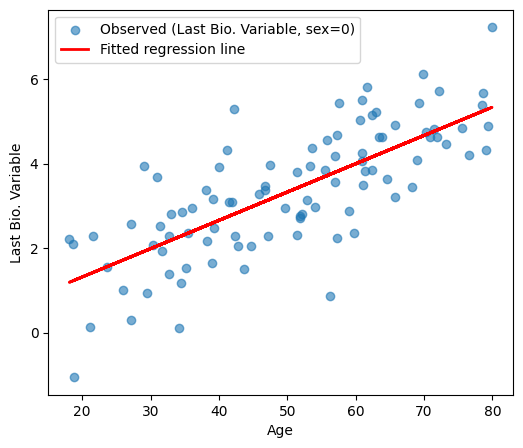

In [ ]:
sex_fixed = 0
feat_name = "Last Bio. Variable"
mask = df["sex"] == sex_fixed # With sex fixed
ages = df.loc[mask, "age"].values
y = X[mask, feat_idx]
y_fit = fitted[mask, feat_idx]

# Plot
plt.figure(figsize=(6,5))
plt.scatter(ages, y, alpha=0.6, label=f"Observed ({feat_name}, sex={sex_fixed})")
plt.plot(ages, y_fit, color="red", linewidth=2, label="Fitted regression line")

plt.xlabel("Age")
plt.ylabel(feat_name)
plt.legend()
plt.show()

In [25]:
# Now, per each feature, we estimate means (gamma_hat) and variances (delta_hat) of the residuals, for a given "site"
n_b = np.zeros(B, dtype=int)
gamma_hat = np.zeros((B, p))
delta_hat = np.zeros((B, p))
for bi, b in enumerate(batches):
    idx = np.where(batch == b)[0]
    n_b[bi] = len(idx)
    Rb = residuals[idx, :]  # (n_b, p)
    gamma_hat[bi, :] = Rb.mean(axis=0)
    # sample variance with ddof=1; ensure positivity
    delta_hat[bi, :] = np.var(Rb, axis=0, ddof=1) + 1e-8

In [30]:
# The residual are supposed to be drawn from prior distributions
def method_of_moments_ig(m, s2):
    # For Inverse-Gamma(a, b) with mean b/(a-1) and var b^2 / ((a-1)^2 (a-2))
    a = (2 * (m**2) / s2) + 2
    b = m * (a - 1)
    return a, b

gamma_bar = gamma_hat.mean(axis=1)  # length B
tau2 = gamma_hat.var(axis=1, ddof=1) + 1e-8  # length B

a = np.zeros(B)
bparam = np.zeros(B)
for bi in range(B):
    m = delta_hat[bi, :].mean()
    s2 = delta_hat[bi, :].var(ddof=1) + 1e-12
    a[bi], bparam[bi] = method_of_moments_ig(m, s2)

In [31]:
gamma_star = np.zeros_like(gamma_hat)
delta_star = np.zeros_like(delta_hat)
for bi in range(B):
    # posterior for variance (expected value under IG posterior)
    # E[delta | data] = (b + 0.5*(n_b-1)*s2) / (a + n_b/2 - 1)
    delta_star[bi, :] = (bparam[bi] + 0.5*(n_b[bi]-1)*delta_hat[bi, :]) / (a[bi] + n_b[bi]/2 - 1)
    # posterior mean for gamma under normal prior with variance tau2 and known variance delta_star/n_b
    gamma_star[bi, :] = (
        (n_b[bi] * gamma_hat[bi, :] / delta_star[bi, :]) + (gamma_bar[bi] / tau2[bi])
    ) / ( (n_b[bi] / delta_star[bi, :]) + (1.0 / tau2[bi]) )

In [32]:
residuals_adj = residuals.copy()
for bi, b in enumerate(batches):
    idx = np.where(batch == b)[0]
    # center & scale with EB parameters
    residuals_adj[idx, :] = (residuals[idx, :] - gamma_star[bi, :]) / np.sqrt(delta_star[bi, :])

In [33]:
X_harmonized = fitted + residuals_adj
# Build a dict of parameters for inspection
params = {
    "gamma_hat": gamma_hat, "delta_hat": delta_hat,
    "gamma_star": gamma_star, "delta_star": delta_star,
    "gamma_bar": gamma_bar, "tau2": tau2, "a": a, "b": bparam,
    "n_b": n_b, "batches": batches
}